## Convolutional Neural Network

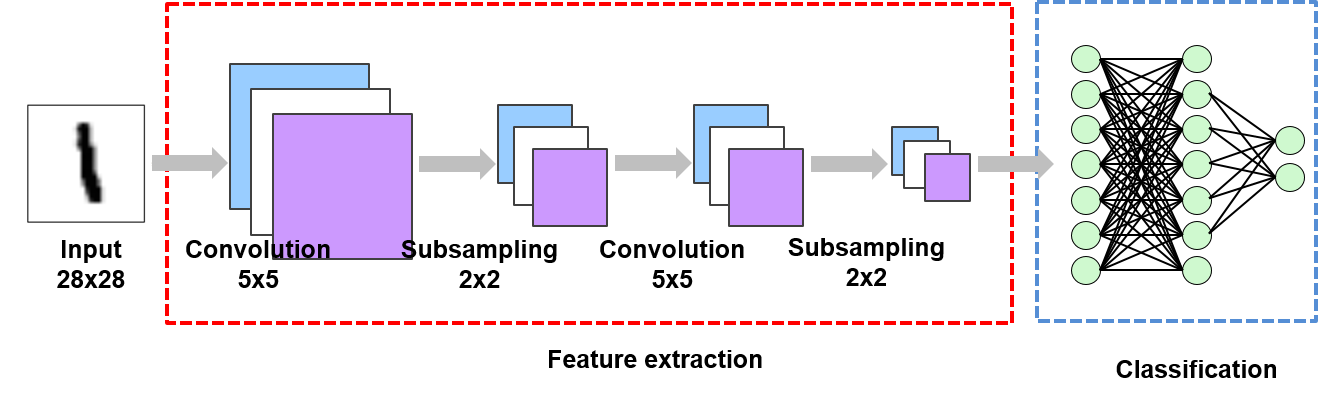

In [2]:
# importing libraries
import os
import os.path
import shutil
import tensorflow as tf

LOGDIR = "/tmp/mnist_tutorial/simple/"
LABELS = os.path.join(os.getcwd(), "labels_1024.tsv")
### Loading the dataset ###
mnist = tf.contrib.learn.datasets.mnist.read_data_sets(train_dir="/tmp/mnist_tutorial/" + "data", one_hot=True)

Extracting /tmp/mnist_tutorial/data\train-images-idx3-ubyte.gz
Extracting /tmp/mnist_tutorial/data\train-labels-idx1-ubyte.gz
Extracting /tmp/mnist_tutorial/data\t10k-images-idx3-ubyte.gz
Extracting /tmp/mnist_tutorial/data\t10k-labels-idx1-ubyte.gz


#### Defining a few layers for our model

In [3]:
# Function defining convolution layer
def conv_layer(input, size_in, size_out, name="conv"):
  #Name sope defines the related ops to have the same naming structure. So all our conv ops will stay grouped
  with tf.name_scope(name):
    w = tf.Variable(tf.truncated_normal([5, 5, size_in, size_out], stddev=0.1), name="W") 
    b = tf.Variable(tf.constant(0.1, shape=[size_out]), name="B")
    # Padding Type- Same: Zero padding, Valid: No padding
    conv = tf.nn.conv2d(input, w, strides=[1, 1, 1, 1], padding="SAME")
    act = tf.nn.relu(conv + b)
    # Summary is TF op that takes in regular tensor from graph & will output protocol buffers that we can write to disk. 
    tf.summary.histogram("weights", w)
    tf.summary.histogram("biases", b)
    tf.summary.histogram("activations", act)
    return tf.nn.max_pool(act, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")

In [4]:
# Function defining Fully Connected layer
def fc_layer(input, size_in, size_out, name="fc"):
  with tf.name_scope(name):
    w = tf.Variable(tf.truncated_normal([size_in, size_out], stddev=0.1), name="W")
    b = tf.Variable(tf.constant(0.1, shape=[size_out]), name="B")
    act = tf.matmul(input, w) + b
    tf.summary.histogram("weights", w)
    tf.summary.histogram("biases", b)
    tf.summary.histogram("activations", act)
    return act

In [5]:
# Define our CNN Model
def mnist_model(learning_rate, use_two_fc, use_two_conv, hparam):
  tf.reset_default_graph()
  sess = tf.Session()

  # Setup placeholders, and reshape the data
  x = tf.placeholder(tf.float32, shape=[None, 784], name="x")
  # Convolution requires a 4 dimensional tensor shaped as Number of Images x Height x Width x Channels. 
  # The negative 1 is indicating that particular dimension should be sized so that the total number of elements remains constant.
  x_image = tf.reshape(x, [-1, 28, 28, 1])
  tf.summary.image('input', x_image, 3)
  y = tf.placeholder(tf.float32, shape=[None, 10], name="labels")

  # Defining structure of layers if there is one or two conv layers
  if use_two_conv:
    conv1 = conv_layer(x_image, 1, 32, "conv1")
    conv_out = conv_layer(conv1, 32, 64, "conv2")
  else:
    conv1 = conv_layer(x_image, 1, 64, "conv")
    conv_out = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")

  flattened = tf.reshape(conv_out, [-1, 7 * 7 * 64])

  # Defining structure of layers if there is one or two FC layers
  if use_two_fc:
    fc1 = fc_layer(flattened, 7 * 7 * 64, 1024, "fc1")
    relu = tf.nn.relu(fc1)
    embedding_input = relu
    tf.summary.histogram("fc1/relu", relu)
    embedding_size = 1024
    logits = fc_layer(fc1, 1024, 10, "fc2")
  else:
    embedding_input = flattened
    embedding_size = 7*7*64
    logits = fc_layer(flattened, 7*7*64, 10, "fc")

  # Defining the cost function as cross_entropy   
  with tf.name_scope("cost"):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            logits=logits, labels=y), name="cost")
    tf.summary.scalar("cost", cost)
  
  # Defining the obtimization algorithm
  with tf.name_scope("train"):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(cost)

  # Computing the accuracy
  with tf.name_scope("accuracy"):
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar("accuracy", accuracy)
  
  # Creates a single target that merges & creates summary for all summary points defined
  summ = tf.summary.merge_all()

  # Embedding visualizer takes on high dimensional data & projects them to 3 dimensions. 
  # Variable that holds the embedding of each of our test set image
  embedding = tf.Variable(tf.zeros([1024, embedding_size]), name="test_embedding")
  assignment = embedding.assign(embedding_input)
  saver = tf.train.Saver()

  sess.run(tf.global_variables_initializer())
  writer = tf.summary.FileWriter(LOGDIR + hparam)
  writer.add_graph(sess.graph)
  
  # Configuration object has information like where can we find all our mnist images, so we can display thumbnails in the browser
  config = tf.contrib.tensorboard.plugins.projector.ProjectorConfig()
  embedding_config = config.embeddings.add()
  embedding_config.tensor_name = embedding.name
  embedding_config.metadata_path = LABELS
  # Specify the width and height of a single thumbnail.
  tf.contrib.tensorboard.plugins.projector.visualize_embeddings(writer, config)

  for i in range(15):
    batch = mnist.train.next_batch(100)
    if i % 2 == 0:
      [train_accuracy, s] = sess.run([accuracy, summ], feed_dict={x: batch[0], y: batch[1]})
      writer.add_summary(s, i)
    if i % 5 == 0:
      sess.run(assignment, feed_dict={x: mnist.test.images[:1024], y: mnist.test.labels[:1024]})
      saver.save(sess, os.path.join(LOGDIR, "model.ckpt"), i)
    sess.run(train_step, feed_dict={x: batch[0], y: batch[1]})

In [6]:
def make_hparam_string(learning_rate, use_two_fc, use_two_conv):
  conv_param = "conv=2" if use_two_conv else "conv=1"
  fc_param = "fc=2" if use_two_fc else "fc=1"
  return "lr_%.0E,%s,%s" % (learning_rate, conv_param, fc_param)


# You can try adding some more learning rates
for learning_rate in [1E-3, 1E-4]:
    # Include "False" as a value to try different model architectures
    for use_two_fc in [True]:
        for use_two_conv in [False, True]:
            # Construct a hyperparameter string for each one (example: "lr_1E-3,fc=2,conv=2")
            hparam = make_hparam_string(learning_rate, use_two_fc, use_two_conv)
            print('Starting run for %s' % hparam)

            # Actually run with the new settings
            mnist_model(learning_rate, use_two_fc, use_two_conv, hparam)
print('Done training!')
print('Run `tensorboard --logdir=%s` to see the results.' % LOGDIR)

Starting run for lr_1E-03,conv=1,fc=2
Starting run for lr_1E-03,conv=2,fc=2
Starting run for lr_1E-04,conv=1,fc=2
Starting run for lr_1E-04,conv=2,fc=2
Done training!
Run `tensorboard --logdir=/tmp/mnist_tutorial/simple/` to see the results.
